# AINE: Biodiversity in Australia

## Visualizing and Preprocessing

##### Getting a quick summary of my data, since there are a lot of columns.

In [1]:
import pandas as pd

#Loading the CSV file into a DataFrame
data = pd.read_csv('0047124-231002084531237.csv', sep='\t')

#getting a quick summary of my large dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127628 entries, 0 to 127627
Data columns (total 50 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   gbifID                            127628 non-null  int64  
 1   datasetKey                        127628 non-null  object 
 2   occurrenceID                      127628 non-null  object 
 3   kingdom                           127628 non-null  object 
 4   phylum                            123176 non-null  object 
 5   class                             121766 non-null  object 
 6   order                             116832 non-null  object 
 7   family                            121686 non-null  object 
 8   genus                             119348 non-null  object 
 9   species                           114219 non-null  object 
 10  infraspecificEpithet              4148 non-null    object 
 11  taxonRank                         127628 non-null  o

##### I am only interested in the occurences located in Australia, so I filter out the rest.

In [2]:
#Filter the dataset to keep only Australian records
australian_data = data[data['countryCode'] == 'AU']


##### Many of the columns do not contain useful information for my project.

In [3]:
#Select and keep the desired columns that I need
columns_to_keep = ["kingdom", "family", "species", "countryCode", "decimalLatitude", "decimalLongitude"]
australian_data = australian_data[columns_to_keep]

##### Since I have many occurences in my dataset, I can afford to drop NaN values

In [4]:
nan_rows = australian_data[australian_data[['family', 'decimalLongitude', 'decimalLatitude']].isna().any(axis=1)]
print(len(nan_rows))  #5179 rows cannot be worked with, and since I still have plenty of occurences, I can afford to drop these rows.


5179


In [5]:
#Drop rows with NaN values in either the "Family", "decimalLongitude or "decimalLatitude" columns
columns_of_interest = ["family", "decimalLongitude", "decimalLatitude"]
australian_data = australian_data.dropna(subset=columns_of_interest)


In [6]:
australian_data.head()


,kingdom,family,species,countryCode,decimalLatitude,decimalLongitude
0,Animalia,Estrildidae,Neochmia temporalis,AU,-35.171013,147.413361
1,Animalia,Scincidae,Ctenotus serventyi,AU,-20.586249,116.804119
2,Animalia,Scincidae,Egernia stokesii,AU,-32.945445,137.514479
3,Animalia,Erebidae,Anomis combinans,AU,-20.280316,148.743116
5,Animalia,Accipitridae,Hieraaetus morphnoides,AU,-29.049227,152.027542


##### Getting Family counts might help me understand class imbalance a bit better

In [7]:
family_counts = australian_data['family'].value_counts()
print(family_counts)  
#since some of the minority classes have only 1 value, and makes it impossible to oversample,
#I will definitely need to implement undersampling techniques for the majority classes


Myrtaceae         7758
Fabaceae          5111
Psittacidae       4327
Orchidaceae       3919
Proteaceae        3600
                  ... 
Meripilaceae         1
Himerometridae       1
Argyresthiidae       1
Macropathidae        1
Aulostomidae         1
Name: family, Length: 1719, dtype: int64


##### visualizing the top 10 different families of the dataset in a pie chart

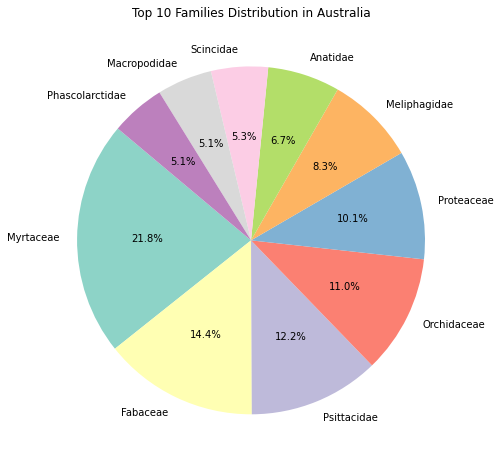

In [8]:

import matplotlib.pyplot as plt

#Get the top 10 families
top_families = family_counts.head(10)

#Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_families, labels=top_families.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
plt.title('Top 10 Families Distribution in Australia')
plt.show()


##### Visualizing the top 10 different families on a colored map

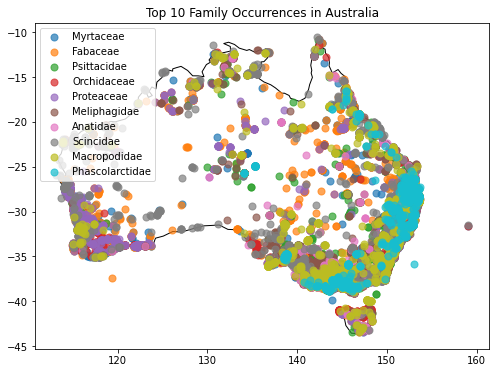

In [9]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

top_family_counts = australian_data['family'].value_counts().head(10).index

#Filtering the DataFrame for the top 10 families
top_family_data = australian_data[australian_data['family'].isin(top_family_counts)]

#Creating a GeoDataFrame
geometry = [Point(xy) for xy in zip(top_family_data['decimalLongitude'], top_family_data['decimalLatitude'])]
top_family_geo_data = gpd.GeoDataFrame(top_family_data, geometry=geometry)

#Creating a colormap with a unique color for each family
colors = plt.cm.tab10.colors  
colormap = ListedColormap(colors[:len(top_family_counts)])

#Ploting each family separately with its own color
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world['name'] == 'Australia'].plot(figsize=(10, 6), edgecolor='black', facecolor='none') 
for family, color in zip(top_family_counts, colors):
    family_subset = top_family_geo_data[top_family_geo_data['family'] == family]
    family_subset.plot(ax=ax, marker='o', color=color, markersize=50, label=family, alpha=0.7)


plt.title('Top 10 Family Occurrences in Australia')
plt.legend()
plt.show()


#biodiversity often thrives in ecologically diverse environments; the distribution makes sense

##### Undersampling the Majority classes

In [10]:
from imblearn.under_sampling import RandomUnderSampler

#Defining the threshold for the number of instances in the majority class
threshold = 2000  

#Getting counts for each class
class_counts = australian_data['family'].value_counts()

#Identifying the majority classes based on my threshold
majority_classes = class_counts.index[class_counts > threshold]

#Filtering the data for the majority classes
majority_data = australian_data[australian_data['family'].isin(majority_classes)]

#Applying RandomUnderSampler to the majority classes
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled_without_family, y_resampled = undersample.fit_resample(majority_data.drop(columns=['family']), majority_data['family'])

#Converting y_resampled to a DataFrame
y_resampled_df = pd.DataFrame(y_resampled, columns=['family'])

#Including 'family' in the X_resampled dataset
X_resampled = pd.concat([X_resampled_without_family, y_resampled_df], axis=1)


## Family Prediction Model

In [11]:
#Ensuring the shapes of X_resampled and y_resampled
print("X_resampled shape:", X_resampled.shape)
print("y_resampled shape:", y_resampled.shape)

#Checking the heads 
print("Sample of X_resampled:")
print(X_resampled.head())  

print("Sample of y_resampled:")
print(y_resampled.head())  


X_resampled shape: (16723, 6)
y_resampled shape: (16723,)
Sample of X_resampled:
      kingdom            species countryCode  decimalLatitude  \
229  Animalia     Cygnus atratus          AU       -35.231903   
266  Animalia  Chenonetta jubata          AU       -37.433730   
271  Animalia  Chenonetta jubata          AU       -38.168355   
288  Animalia     Cygnus atratus          AU       -33.902692   
324  Animalia  Chenonetta jubata          AU       -36.454505   

     decimalLongitude    family  
229        149.156754  Anatidae  
266        143.908255  Anatidae  
271        146.689185  Anatidae  
288        151.234117  Anatidae  
324        146.023954  Anatidae  
Sample of y_resampled:
229    Anatidae
266    Anatidae
271    Anatidae
288    Anatidae
324    Anatidae
Name: family, dtype: object


In [12]:
from sklearn.preprocessing import LabelEncoder

#Encoding the 'family' labels so that it works with my neural network
label_encoder = LabelEncoder()
y_resampled_encoded = label_encoder.fit_transform(y_resampled)


In [38]:
#Splitting the data in training/validation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled[['decimalLatitude', 'decimalLongitude']], y_resampled_encoded, test_size=0.2, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split


model = Sequential()

#Adding layers
model.add(Dense(128, activation='relu', input_shape=(2,)))  #2 features: decimalLatitude, decimalLongitude
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))  #Additional layer
model.add(Dense(1719, activation='softmax'))  #1719 is the amount of different family categories in my data

#Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Training the model
model.fit(X_train, y_train, epochs=300, batch_size=60, validation_data=(X_validation, y_validation))


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", test_accuracy)


Epoch 1/300
168/168 [==============================] - 4s 21ms/step - loss: 2.6719 - accuracy: 0.1271 - val_loss: 1.9501 - val_accuracy: 0.1426
Epoch 2/300
168/168 [==============================] - 3s 19ms/step - loss: 1.9599 - accuracy: 0.1428 - val_loss: 1.9498 - val_accuracy: 0.1405
Epoch 3/300
168/168 [==============================] - 3s 16ms/step - loss: 1.9510 - accuracy: 0.1558 - val_loss: 1.9806 - val_accuracy: 0.1366
Epoch 4/300
168/168 [==============================] - 3s 15ms/step - loss: 1.9455 - accuracy: 0.1653 - val_loss: 1.9554 - val_accuracy: 0.2182
Epoch 5/300
168/168 [==============================] - 3s 18ms/step - loss: 1.9367 - accuracy: 0.1781 - val_loss: 1.9334 - val_accuracy: 0.1731
Epoch 6/300
168/168 [==============================] - 3s 18ms/step - loss: 1.9194 - accuracy: 0.1893 - val_loss: 1.9123 - val_accuracy: 0.1961
Epoch 7/300
168/168 [==============================] - 3s 17ms/step - loss: 1.9083 - accuracy: 0.1898 - val_loss: 1.9063 - val_accuracy:

## Evaluation Metrics

In [42]:
from sklearn.metrics import f1_score


y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)  #Converting predicted probabilities to predicted class labels

#Calculating the F1-score
f1 = f1_score(y_test, y_pred_classes, average='weighted') 

print("F1 Score:", f1)


F1 Score: 0.28759179135698654


In [43]:
from sklearn.metrics import classification_report

#Getting classification report for the test set
class_report_test = classification_report(y_test, y_pred_classes)
print(class_report_test)


              precision    recall  f1-score   support

           0       0.35      0.65      0.46       477
           1       0.26      0.19      0.22       456
           2       0.22      0.12      0.15       508
           3       0.38      0.61      0.47       494
           4       0.28      0.23      0.25       487
           5       0.40      0.09      0.15       466
           6       0.30      0.35      0.32       457

    accuracy                           0.32      3345
   macro avg       0.31      0.32      0.29      3345
weighted avg       0.31      0.32      0.29      3345



In [36]:
from sklearn.preprocessing import LabelEncoder


inverse_encoded_labels = label_encoder.inverse_transform([0, 1, 2, 3, 4, 5, 6])

#Printing the original family labels corresponding to the encoded classes
print(inverse_encoded_labels)


['Anatidae' 'Fabaceae' 'Meliphagidae' 'Myrtaceae' 'Orchidaceae'
 'Proteaceae' 'Psittacidae']
